In [1]:
import numpy as np
np.set_printoptions(precision=3)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(rc={"figure.dpi":100, "savefig.dpi":300})
sns.set_context("notebook")
sns.set_style("ticks")

import scipy.stats as st

def plot_1d_regression(
    x_star,
    gpm,
    ax=None,
    f_true=None,
    num_samples=10
):
    """Plot the posterior predictive.
    
    Arguments
    x_start  --  The test points on which to evaluate.
    gpm      --  The trained model.
    
    Keyword Arguments
    ax          --  An axes object to write on.
    f_true      --  The true function.
    num_samples --  The number of samples.
    """
    m_star, v_star = gpm.predict(x_star)

    f_lower = (
        m_star - 2.0 * np.sqrt(v_star - gpm.likelihood.variance)
    )
    f_upper = (
        m_star + 2.0 * np.sqrt(v_star - gpm.likelihood.variance)
    )
    
    if ax is None:
        fig, ax = plt.subplots()
    
    ax.plot(x_star, m_star, lw=2, label='$m_n(x)$')
   
    ax.fill_between(
        x_star.flatten(),
        f_lower.flatten(),
        f_upper.flatten(),
        alpha=0.5,
        label='$f(\mathbf{x}^*)$ 95% pred.'
    )
    
    if f_true is not None:
        ax.plot(
            x_star,
            f_true(x_star),
            'm-.',
            label='True function'
        )

    if num_samples > 0:
        f_post_samples = gpm.posterior_samples_f(
            x_star,
            num_samples
        )
        ax.plot(x_star, f_post_samples[:, 0, :], 'r', lw=0.5)
        ax.plot([], [], 'r', lw=0.5, label="Posterior samples")

    ax.plot(gpm.X,
            gpm.Y,
            'kx',
            markersize=5,
            markeredgewidth=2,
            label='Observations'
    )

    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')

    plt.legend(loc='best')
    
    return m_star, v_star


def plot_iaf(
    x_star,
    gpr,
    alpha,
    alpha_params={},
    ax=None,
    f_true=None
):
    """Plot the information acquisition function.
    
    Arguments
    x_star       -- A set of points to plot on.
    gpr          -- A rained Gaussian process regression
                    object.
    alpha        -- The information acquisition function.
                    This assumed to be a function of the
                    posterior mean and standard deviation.
              
    Keyword Arguments
    ax           -- An axes object to plot on.
    f_true       -- The true function - if available.
    
    The evaluation of the informationa acquisition function
    is as follows:
    
        af_values = alpha(mu, sigma, y_max, **alpha_params)

    """
    if ax is None:
        fig, ax = plt.subplots()
    
    ax.set_title(
        ", ".join(
            f"{n}={k:.2f}"
            for n, k in alpha_params.items()
            )
    )
    
    m, v = plot_1d_regression(
        x_star,
        gpr,
        ax=ax,
        f_true=f_true,
        num_samples=0
    )
    
    # THIS CHANGED FROM THE PREVIOUS VERSION
    sigma = np.sqrt(v - gpr.likelihood.variance)
    af_values = alpha(m, sigma, Y.max(), **alpha_params)
    next_id = np.argmax(af_values)
    next_x = x_star[next_id]
    af_max = af_values[next_id]
    
    ax2 = ax.twinx()
    ax2.plot(x_star, af_values, color=sns.color_palette()[1])
    ax2.set_ylabel(
        'Maximum Upper Interval',
        color=sns.color_palette()[1]
    )
    plt.setp(
        ax2.get_yticklabels(),
        color=sns.color_palette()[1]
    )
    ax2.plot(
        next_x * np.ones(100),
        np.linspace(0, af_max, 100),
        color=sns.color_palette()[1],
        linewidth=1
    )
    
def maximize(
    f,
    gpr,
    X_design,
    alpha,
    alpha_params={},
    max_it=10,
    optimize=False,
    plot=False,
    **kwargs
):
    """Optimize a function using a limited number of evaluations.
    
    Arguments
    f            -- The function to optimize.
    gpr          -- A Gaussian process model to use for representing
                    our state of knowldege.
    X_design     -- The set of candidate points for identifying the
                    maximum.
    alpha        -- The information acquisition function.
                    This assumed to be a function of the
                    posterior mean and standard deviation.
    
    Keyword Arguments
    alpha_params -- Extra parameters to the information
                    acquisition function.
    max_it       -- The maximum number of iterations.
    optimize     -- Whether or not to optimize the hyper-parameters.
    plot         -- Determines how often to plot. Make it one
                    to plot at each iteration. Make it max_it
                    to plot at the last iteration.
                    
    The rest of the keyword arguments are passed to plot_iaf().
    """
    af_all = []
    for count in range(max_it):
        # Predict
        m, sigma2 = gpr.predict(X_design)
        # THIS CHANGED FROM THE PREVIOUS VERSION
        sigma = np.sqrt(sigma2 - gpr.likelihood.variance)
        
        # Evaluate information acquisition function
        af_values = alpha(
            m,
            sigma,
            gpr.Y.max(),
            **alpha_params
        )
        
        # Find best point to include
        i = np.argmax(af_values)
        X = np.vstack([gpr.X, X_design[i:(i+1), :]])
        af_all.append(af_values[i])

        # Make observation
        y = np.vstack([gpr.Y, [f(X_design[i, :])]])
        # Update GPR
        gpr.set_XY(X, y)
        if optimize:
            gpr.optimize()
        
        # Plot if required
        if count % plot == 0:
            if "ax" in kwargs:
                ax = kwargs[ax]
            else:
                fig, ax = plt.subplots()
            plot_iaf(
                X_design,
                gpr,
                alpha,
                alpha_params=alpha_params,
                f_true=f,
                ax=ax
            )
            ax.set_title(
                f"N={count}, " + ax.get_title()
            )
    return af_all


def mui(m, sigma, ymax, psi=1.96):
    """The maximum upper interval acquisition function."""
    return m + psi * sigma


def poi(m, sigma, ymax, psi=0.):
    """Return the probability of improvement.
    
    Arguments
    m     -- The predictive mean at the test points.
    sigma -- The predictive standard deviation at
             the test points.
    ymax  -- The maximum observed value (so far).
    psi   -- A parameter that controls exploration.
    """
    return st.norm.cdf((m - ymax - psi) / sigma)

def ei(m, sigma, ymax):
    """Return the expected improvement.
    
    Arguments
    m     -- The predictive mean at the test points.
    sigma -- The predictive standard deviation at
             the test points.
    ymax  -- The maximum observed value (so far).
    """
    u = (m - ymax) / sigma
    ei = sigma * (u * st.norm.cdf(u) + st.norm.pdf(u))
    ei[sigma <= 0.] = 0.
    return ei

# Expected Improvement - With Observation Noise

## Objectives

+ Develop intuition about the expected improvement in the presence of observation noise

## Optimizing Noisy Functions

The optimization of noisy functions is relevant when you are dealing with experimentally measured objectives.
In such a scenario, you do not observe $f(\mathbf{x})$, but a noisy version of it.
Here is a prototypical scenario of an experimentally measured objective.
Let $\xi$ be all the variables that affect the objective and assume that they are distributed in a way, not necessarily known to you:

$$
\xi \sim p(\xi).
$$

The you setup your experiment using a design $\mathbf{x}$ and you measure:

$$
y = g(\mathbf{x}, \xi).
$$

Let's assume now, that you would like to maximize the expectation of this function, i.e., you want to maximize

$$
f(\mathbf{x}) = \mathbb{E}_\xi[g(\mathbf{x},\xi)].
$$

The expectation here is over the experimental noise.

A naïve way of solving this problem is to approximate the expectation using sample averaging.
That is, at each $\mathbf{x}$ you do many experiments instead of just one.
If your experiments are not very expensive, you may just do that.
Then any of the algorithms above would work in your problem.

So, what do you do when you cannot get rid of the noise?
Well, this is an open problem.
But here is a quick and dirty solution which may work in many cases.
First, use GPR to approximate $f(\mathbf{x})$ using noisy measurements:

$$
y_i = g(\mathbf{x},\xi_i),
$$

for $i=1,\dots,n$. 
Note that here you do not necessarily have to observe the $\xi$'s.
You can assume that they are hidden. If you do observe them, you can exploit this fact.
But, for now, let's assume that you don't observe them.
If you don't observe them you need to somehow model their effect.
The easier thing to do is to assume that their effect is additive, zero mean, and Gaussian.
That is, we just assume that:

$$
y_i = f(\mathbf{x}_i) + \epsilon_i,
$$

where $\epsilon_i \sim \mathcal{N}(0,\sigma^2)$, where $\sigma^2$ is to be determined.
Of course, this is, in general, not the right assumption for the noise.
It is, however, the easiest thing to do.
When we do this, we can just use GPR to find our posterior state of knowledge about $f(\cdot)$ and any hyperparameters).
We will be just using a MAP estimate for the hyperparameters.

The posterior GP conditioned on the observed data is given by the usual formulas:

$$
f(\cdot)|\mathcal{D}_n \sim \operatorname{GP}(m_n(\cdot), k_n(\cdot,\cdot)).
$$

Since we will be doing sequential experiment design, we are also going to need the point-predictive distribution for the measurement $y$ at a hypothetical $\mathbf{x}$.
It is:

$$
p(y|\mathbf{x},\mathcal{D}_n) = \mathcal{N}(y|m_n(\mathbf{x}), \sigma_n^2(\mathbf{x}) + \sigma^2),
$$

where $\sigma_n^2(\mathbf{x}) = k_n(\mathbf{x},\mathbf{x})$, i.e., the posterior variance for $f(\mathbf{x})$.
We now have all the ingredients to modify the information acquisition functions we had above for the noisy cases.

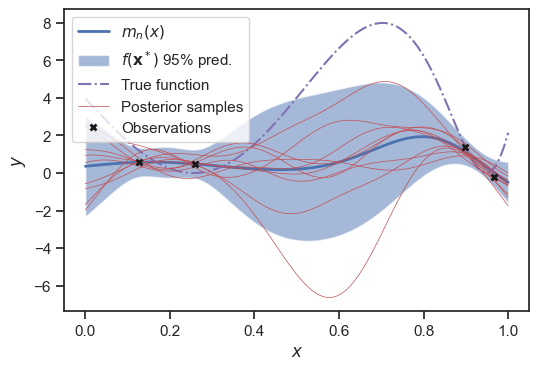

In [2]:
np.random.seed(123456)


def f(x):
    """A function to optimize."""
    return 4 * (1. - np.sin(6 * x + 8 * np.exp(6 * x - 7.))) 

# noisy version of the above function
sigma_noise = 0.4
g = lambda x: (
    f(x)
    + sigma_noise * np.random.randn(x.shape[0])
)

# Generate some data:
n_init = 4
X = np.random.rand(n_init)
Y = g(X)

# Do GPR
import GPy
k = GPy.kern.RBF(1, lengthscale=0.15, variance=4.)
gpr = GPy.models.GPRegression(X[:, None], Y[:, None], k)
gpr.likelihood.variance.constrain_fixed(sigma_noise ** 2)

# Plot posterior predictive
x_star = np.linspace(0, 1, 100)[:, None]
plot_1d_regression(
    x_star,
    gpr,
    f_true=f
);

## Maximum upper interval with noise

The maximum upper interval remains the same:

$$
a_n(\mathbf{x}) = \mu_n(\mathbf{x}) + \psi \sigma_n(\mathbf{x}),
$$

for some $\psi \ge 0$.
Just make sure you don't add the $\sigma^2$ term in the variance.
Of course, we need to modify the way we grab the variance from ``GPy`` for this.
Here it is:

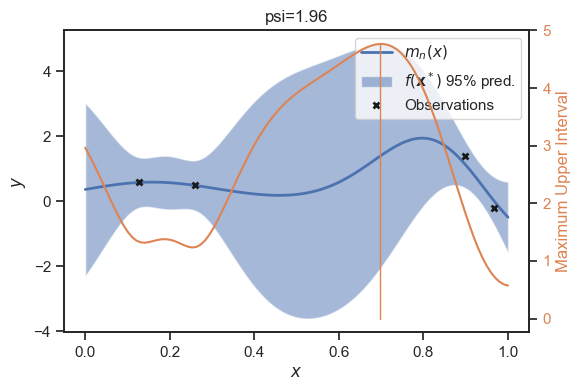

In [3]:
plot_iaf(
    x_star,
    gpr,
    mui,
    alpha_params=dict(psi=1.96)
)

## Probability of improvement with noise

We need to make some modifications to the probability of improvement.
First, we cannot just use the $y_n^*$ as the maximum of the $y_i$'s, because they are noisy.
Instead, we are looking at the predictive mean of the GP, $m_n(\mathbf{x}_i)$, at the corresponding inputs, $\mathbf{x}_i$, and we find their maximum.
So, define:

$$
m_n^* = \max_{1\le i\le n}m_n(\mathbf{x}_i).
$$

Essentially, instead of finding the maximum of the noisy observations, we are smoothing with the predictive mean of the GP and find the maximum of the smoothed versions.
The rest is similar.
The acquisition function is defined by:

$$
a_n(\mathbf{x}) = \mathbb{P}[f(\mathbf{x}) > m_n^* + \psi | \mathbf{x}, \mathcal{D}_n].
$$

We read "$a_n(\mathbf{x})$" is the probability that we observe at $x$ a $y$ that is greater than the currently observed maximum $y_n^*$ by at least $\psi>0$.
The good thing is that it is possible to get an analytical answer because our point predictive distribution is Gaussian.
In particular, we get:

$$
\begin{align}
a_n(\mathbf{x}) &=& \mathbb{P}[f(\mathbf{x}) > m_n^* + \psi | \mathbf{x}, \mathcal{D}_n]\\
&=& \mathbb{P}\left[\frac{f(\mathbf{x}) - \mu_n(\mathbf{x})}{\sigma_n(\mathbf{x})} > \frac{m_n^* + \psi - \mu_n(\mathbf{x})}{\sigma_n(\mathbf{x})} \Big| \mathbf{x}, \mathcal{D}_n\right]\\
&=& \dots\\
&=& \Phi\left(\frac{\mu_n(\mathbf{x}) - m_n^* - \psi}{\sigma_n(\mathbf{x})} \right).
\end{align}
$$

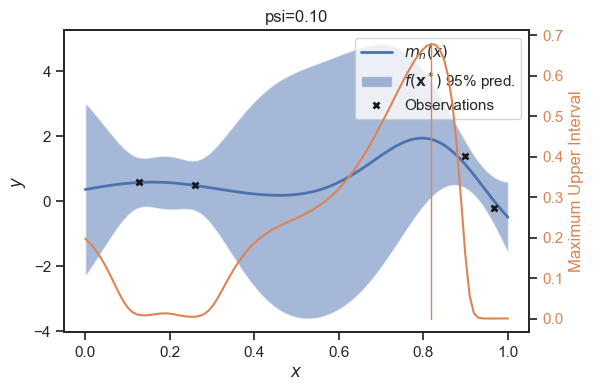

In [4]:
plot_iaf(
    x_star,
    gpr,
    poi,
    alpha_params=dict(psi=0.1)
)

## Expected improvment with noise

The arguments here are as in the previous section about the probability of improvement.
Consider a hypothetical experiment at $\mathbf{x}$ and assume that you observed $y$.
How much improvement is that compared to your currently best observed point $m_n^*$.
It is:

$$
I_n(\mathbf{x}, f(\mathbf{x})) =
\begin{cases}
0,&\;\text{if}\;f(\mathbf{x}) \le m_n^*,\\
f(\mathbf{x}) - m_n^*,&\;\text{otherwise},
\end{cases}
$$

and this conditional of $y$, i.e., $f(\mathbf{x})$ is a random variable conditioned on $y$.
Taking the expectation over $y$ would give you:

$$
\operatorname{EI}_n(\mathbf{x}) = \frac{m_n(\mathbf{x}) - m_n^*}{\sigma_n(\mathbf{x})}\Phi\left(\frac{m_n(\mathbf{x}) - m_n^*}{\sigma_n(\mathbf{x})}\right)
+ \phi\left(\frac{m_n(\mathbf{x}) - m_n^*}{\sigma_n(\mathbf{x})}\right).
$$

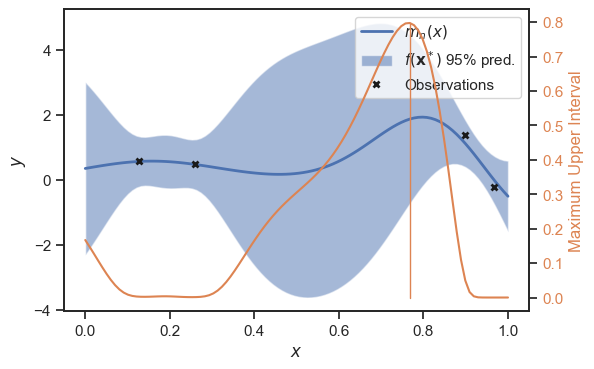

In [5]:
plot_iaf(
    x_star,
    gpr,
    ei
)

And here optimization with noise:

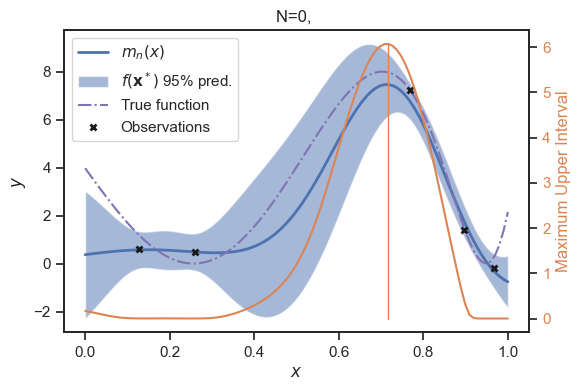

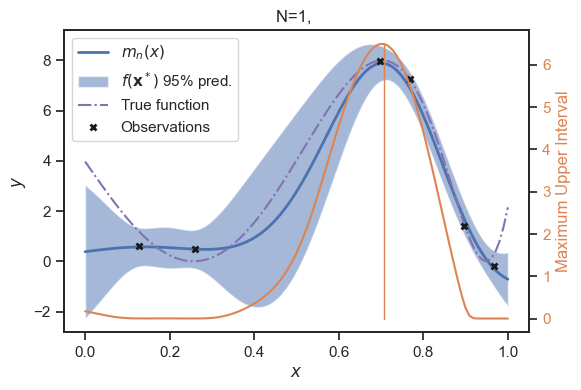

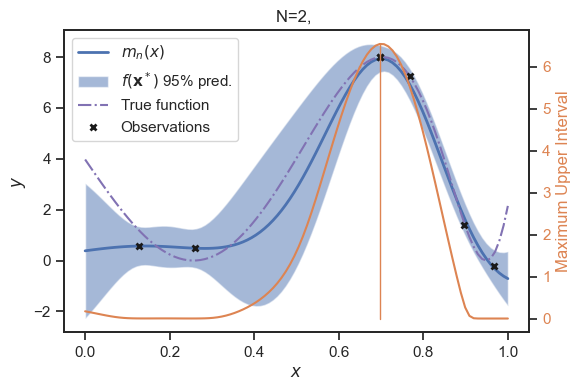

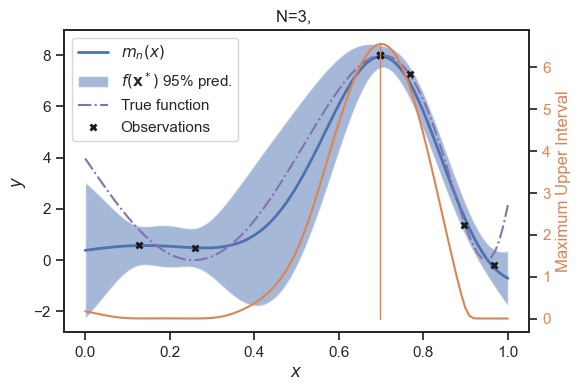

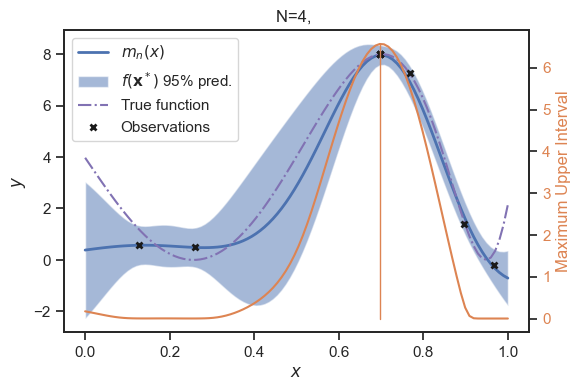

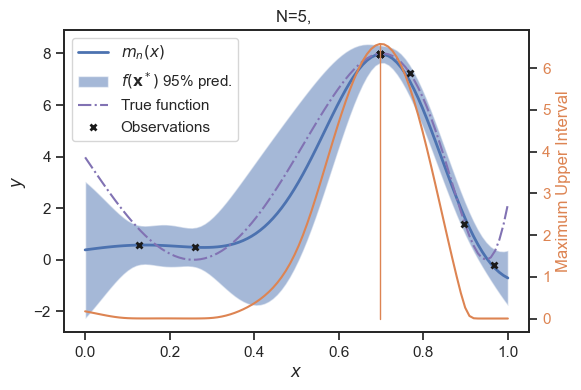

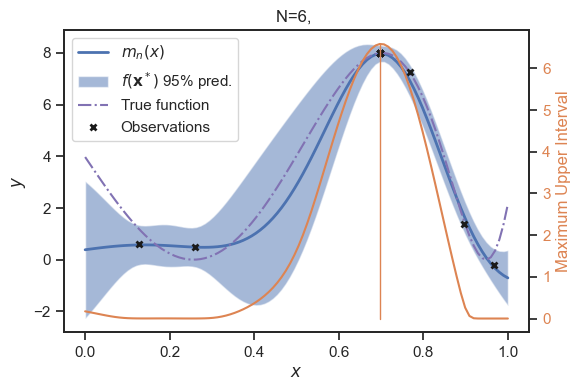

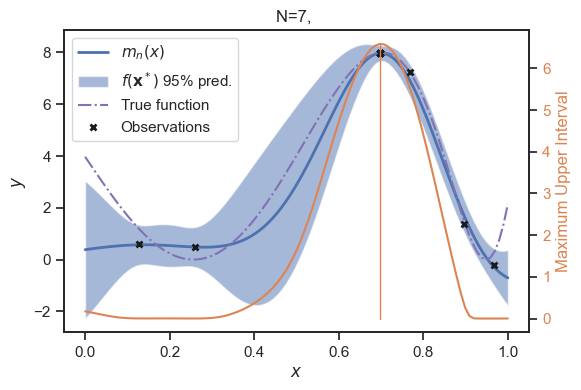

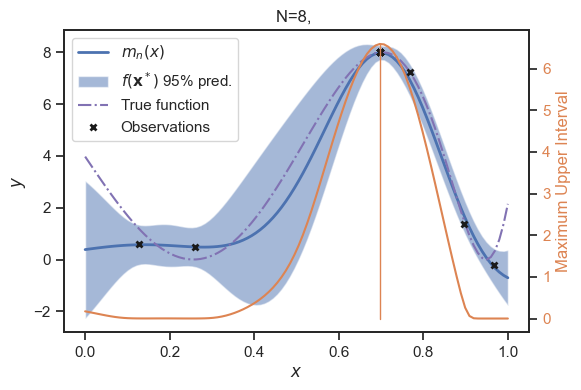

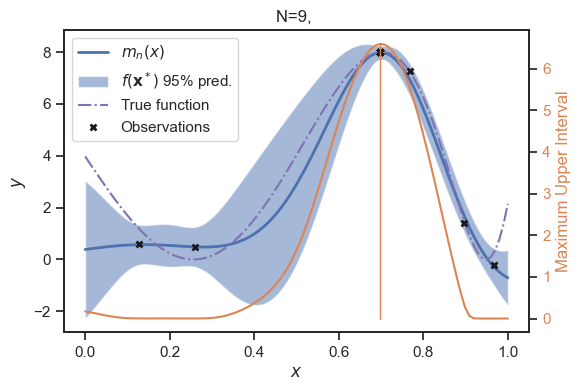

In [6]:
# Prepare the initial statistical model
k = GPy.kern.RBF(1, lengthscale=0.15, variance=4.)
gpr = GPy.models.GPRegression(X[:, None], Y[:, None], k)
gpr.likelihood.variance.constrain_fixed(sigma_noise ** 2)

# Run the algorithm
af_all = maximize(
    f,
    gpr,
    x_star,
    ei,
    max_it=10,
    plot=1
)

## Questions

+ Rerun the algorithm above starting with 3 observations. Does the algorithm find the same local maximum?
If not, why?
+ Experiment with smaller noise. 
+ Experiment with larger noise.